We're going to do the easy case, working with the images that have had their background removed. And for performance reasons we're going to work with a sample of the data. 

In [1]:
COUNT = 500
TRAIN = '/kaggle/input/categorized-medical-waste-image-dataset/Dataset/Baackground_Removed'

We want to get image embeddings, for both EDA and classification, so let's add some code that will get those for us from ResNeXt.

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 169MB/s]


Next let's load up our data; this is going to take a while, because we're loading a lot of images per class, and we have a lot of classes.

In [3]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'])
        for index, input_file in enumerate(list(iglob(pathname=arg))) if index < COUNT]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*')}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))

print('done in {}'.format(arrow.now() - time_start))

encoded 500 rows of ampoules_full  in 0:01:12.663625
encoded 500 rows of iv_bottles  in 0:08:26.640152
encoded 500 rows of stitch_removal_scissors  in 0:01:14.600061
encoded 500 rows of used_medical_paper  in 0:01:22.038540
encoded 500 rows of used_syringes  in 0:01:15.251242
encoded 500 rows of hemostats  in 0:01:15.375547
encoded 500 rows of general_organic_waste  in 0:01:21.335774
encoded 500 rows of forceps  in 0:01:14.610375
encoded 500 rows of waterbottles  in 0:01:48.370587
encoded 500 rows of tweezers  in 0:01:28.967780
encoded 500 rows of disinfectant_bottles  in 0:01:08.504074
encoded 500 rows of blood_soaked_bandages  in 0:01:34.785062
encoded 500 rows of vaccine_or_medicine_vials  in 0:01:06.049650
encoded 500 rows of syrup_bottles  in 0:01:05.695142
encoded 500 rows of used_medical_gloves  in 0:01:20.966254
encoded 500 rows of mayo_scissors  in 0:01:12.317736
encoded 500 rows of uncategorized_or_overlapping  in 0:01:19.702710
encoded 500 rows of scalpels  in 0:01:13.240260

Our target classes are balanced by construction, but let's look at the class counts anyway.

In [4]:
train_df['tag'].value_counts().to_frame()

count
tag                                
ampoules_full                   500
vaccine_or_medicine_vials       500
ampuoles_broken                 500
expired_tablets                 500
human_organs                    500
episiotomy_scissors             500
scalpels                        500
uncategorized_or_overlapping    500
mayo_scissors                   500
used_medical_gloves             500
syrup_bottles                   500
blood_soaked_bandages           500
iv_bottles                      500
disinfectant_bottles            500
tweezers                        500
waterbottles                    500
forceps                         500
general_organic_waste           500
hemostats                       500
used_syringes                   500
used_medical_paper              500
stitch_removal_scissors         500
used_masks                      500

Next let's use TSNE to get x/y coordinates based on our image vectors. 

In [5]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 11500 samples in 0.068s...
[t-SNE] Computed neighbors for 11500 samples in 10.008s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11500
[t-SNE] Computed conditional probabilities for sample 2000 / 11500
[t-SNE] Computed conditional probabilities for sample 3000 / 11500
[t-SNE] Computed conditional probabilities for sample 4000 / 11500
[t-SNE] Computed conditional probabilities for sample 5000 / 11500
[t-SNE] Computed conditional probabilities for sample 6000 / 11500
[t-SNE] Computed conditional probabilities for sample 7000 / 11500
[t-SNE] Computed conditional probabilities for sample 8000 / 11500
[t-SNE] Computed conditional probabilities for sample 9000 / 11500
[t-SNE] Computed conditional probabilities for sample 10000 / 11500
[t-SNE] Computed conditional probabilities for sample 11000 / 11500
[t-SNE] Computed conditional probabilities for sample 11500 / 11500
[t-SNE] Mean sigma: 3.542777
[t-SNE] KL divergenc

Now we're ready to plot. We're going to plot just a sample of our data, for performance reasons.

In [6]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']].sample(n=2000, random_state=2025))
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: medical waste', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? Some of our data clusters nicely, in that classes are tight and isolated. Some of our data clusters somewhat but isn't isolated (see e.g. the instruments). And some of our data is a mixed mess; this is especially true where the background removal appears to have failed and left us a black image. We should have moderate expectations regarding model accuracy. Let's build a model and see what we get.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['tag'], test_size=0.25, random_state=2025, stratify=train_df['tag'])
logreg = LogisticRegression(max_iter=10000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 610 iterations
accuracy: 0.9388
f1: 0.9387
                              precision    recall  f1-score   support

               ampoules_full       0.92      0.92      0.92       125
             ampuoles_broken       0.88      0.84      0.86       125
       blood_soaked_bandages       0.95      0.91      0.93       125
        disinfectant_bottles       0.89      0.90      0.90       125
         episiotomy_scissors       0.96      0.94      0.95       125
             expired_tablets       0.94      0.89      0.91       125
                     forceps       0.98      0.96      0.97       125
       general_organic_waste       0.98      0.98      0.98       125
                   hemostats       0.97      0.94      0.95       125
                human_organs       0.88      0.91      0.89       125
                  iv_bottles       1.00      0.98      0.99       125
               mayo_scissors       0.94      0.96      0.95       125
                    scalpels     

Frankly an f1 of 0.9 is pretty good given the quality of our data. Let's take a look at the model probabilities.

<Axes: xlabel='probability', ylabel='Count'>

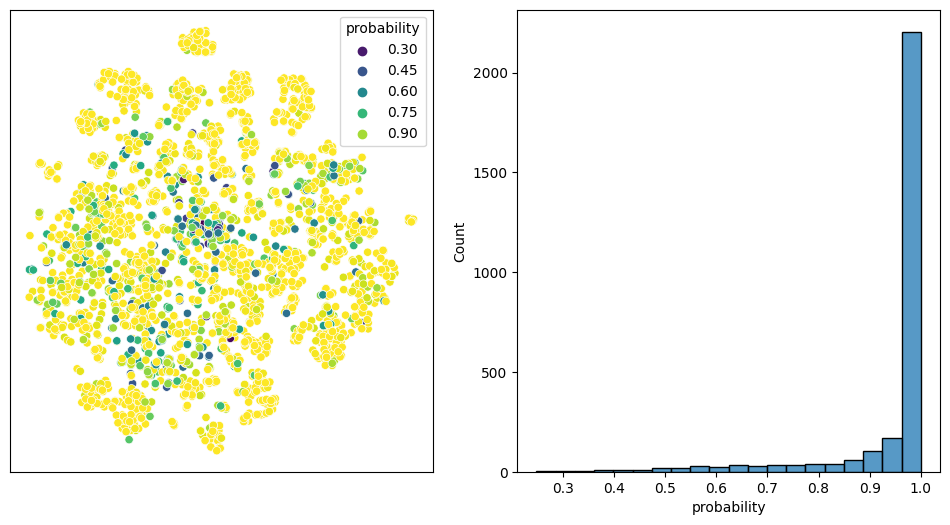

In [8]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')


plot_df = train_df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis')
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)

Not surprisingly, our model probabilities are high where we have tight clusters in our interactive plot above, and low probabilities where we don't.